# 系统在噪音下的特性

In [1]:
# 导入必要的包
from qutip import *
import numpy as np
from matplotlib import pyplot as plt
import scipy

In [2]:
# 构建升降算符
N = 50 # 空间维度
a = destroy(N)
a_dag = a.dag()

# 定义常数
K = 1

## Thermal bath

In [3]:
# 定义常数
kappa = K/400
n_th = 0.01

# 耗散算符
c_th_1 = np.sqrt(kappa * (n_th + 1)) * a
c_th_2 = np.sqrt(kappa * n_th) * a.dag()

## 双光子耗散

In [4]:
# 定义常数
kappa_2 = K/10
c_2pn = np.sqrt(kappa_2) * a * a

# 稳定猫态需要在不同的双光子耗散速率下下施加不同相位的驱动
phi_0 = np.arctan(kappa_2/(2*K)) / 2

## 猫态下的泡利算符

In [5]:
def pauli_basis(alp, phi=phi_0):
    # 定义在驱动含有相位时的有效 alpha
    alp = alp * np.exp(1j * phi)
    # 获取猫态
    cat1 = (coherent(N, alp) + coherent(N, -alp)).unit()
    cat2 = (coherent(N, alp) - coherent(N, -alp)).unit()

    # 定义计算基矢
    pole1 = (cat1 + cat2) / np.sqrt(2)
    pole2 = (cat1 - cat2) / np.sqrt(2)

    # 定义猫态编码下的 Pauli 算符
    I = pole1 * pole1.dag() + pole2 * pole2.dag()
    X = pole1 * pole2.dag() + pole2 * pole1.dag()
    Y = -1j * (pole1 * pole2.dag() - pole2 * pole1.dag())
    Z = pole1 * pole1.dag() - pole2 * pole2.dag()

    return [I, X, Y, Z]

## 构建哈密顿量

In [6]:
# 定义不同的猫态大小 alpha
n_alp = 16  # alpha 的数量
alphas = np.linspace(1, 4, n_alp)

In [7]:
# 构建不同猫态大小下的哈密顿量和泡利算符
H_0s = []
paulis = []

for alp in alphas:
    P = alp ** 2 * np.sqrt(K**2 + (kappa_2 ** 2) / 4)
    H_0 = -K * a_dag * a_dag * a * a + P * (a_dag * a_dag * np.exp(2j * phi_0) + a * a * np.exp(-2j * phi_0))
    paulis.append(pauli_basis(alp))
    H_0s.append(H_0)

## 系统演化求解

In [8]:
# 演化总时间
t = 50 / K

# 时间切片
n_time = 100    # 时间切片个数
times = np.linspace(0, t, n_time)

In [9]:
# 演化到最后时刻 t 的状态
def state_end(initial_state, n):
    """
    param: initial_state: 初始状态
    param: n: 在第几个猫态大小下求解
    """
    # 获取第几个猫态大小 alpha 下的哈密顿量
    H_0 = H_0s[n]
    
    # 求解系统演化
    res = mesolve(H_0, initial_state, times, [c_th_1, c_th_2, c_2pn], [], options=Options(nsteps=10000))
    
    # 返回最后一个时刻的状态
    return res.states[n_time-1]

## Quantum process tomegraphy

In [10]:
# Pauli transfer matrix
def PTM(n):
    """
    param: n: 第几个猫态大小 alpha 下的PTM
    """
    matrix = []
    for pauli in paulis[n]:
        matrix.append([(1/2) * (pauli * state_end(pauli_, n)).tr() for pauli_ in paulis[n]])
    
    return matrix

In [11]:
# 将 PTM 转为 choi 矩阵
def PTM_to_choi(PTM, d=2):
    """
    choi 矩阵是一个密度矩阵
    """
    pauli = [qeye(d), sigmax(), sigmay(), sigmaz()]
    rho = 0
    for i in range(d**2):
        for j in range(d**2):
            rho += PTM[i][j] * tensor(pauli[j].trans(), pauli[i])
    
    rho /= d**2
    
    return rho

In [12]:
# M1 = PTM(3)

In [13]:
# M1

In [14]:
# choi1 = PTM_to_choi(M1)

In [15]:
# chi1 = choi_to_chi(choi1)

In [16]:
# chi1_u = chi1.unit()

In [17]:
# chi1_u

In [18]:
# chi1

In [19]:
lambda_II = []
lambda_IX = []
lambda_XX = []
lambda_YY = []
lambda_YZ = []
lambda_ZZ = []
for i in range(n_alp):
    M = PTM(i)
    choi = PTM_to_choi(M)
    chi_u = choi_to_chi(choi).unit()
    chi_u_element = lambda i,j: np.log(np.abs(chi_u[i][0][j]))
    lambda_II.append(chi_u_element(0,0))
    lambda_IX.append(chi_u_element(0,1))
    lambda_XX.append(chi_u_element(1,1))
    lambda_ZZ.append(chi_u_element(3,3))
    lambda_YY.append(chi_u_element(2,2))
    lambda_YZ.append(chi_u_element(2,3))


In [20]:
def plot_lambda(lambda_):
    plt.figure(figsize=(5,10), dpi=80)
    plt.scatter(alphas, lambda_)
    plt.plot(alphas, lambda_)
    plt.show()

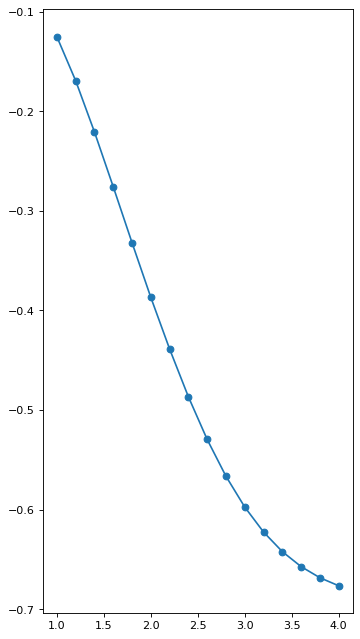

In [21]:
plot_lambda(lambda_II)

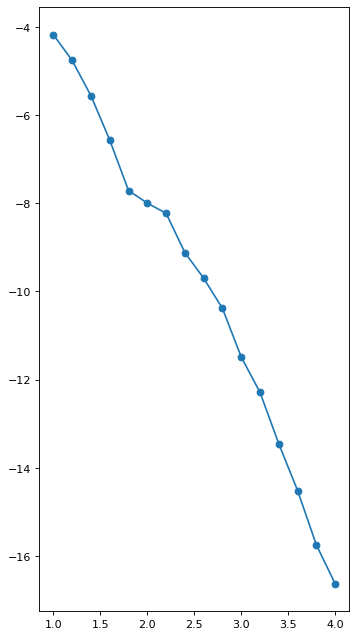

In [22]:
plot_lambda(lambda_IX)

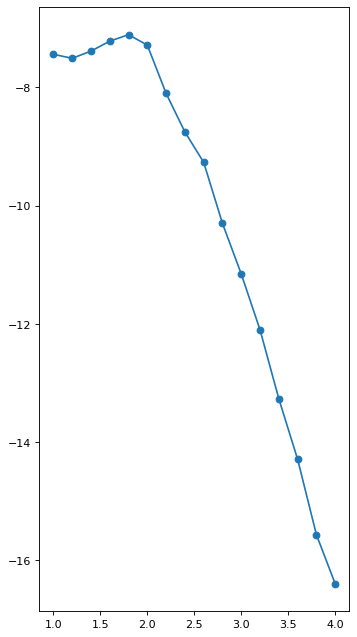

In [23]:
plot_lambda(lambda_XX)

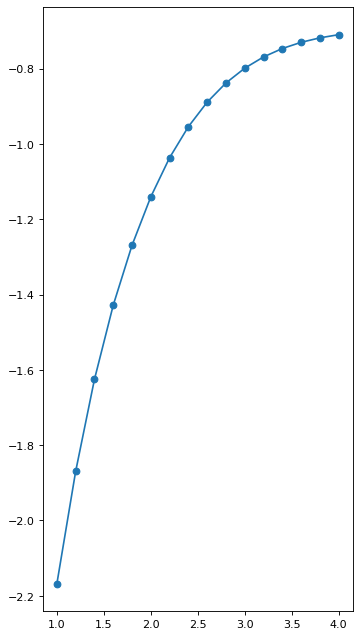

In [24]:
plot_lambda(lambda_ZZ)

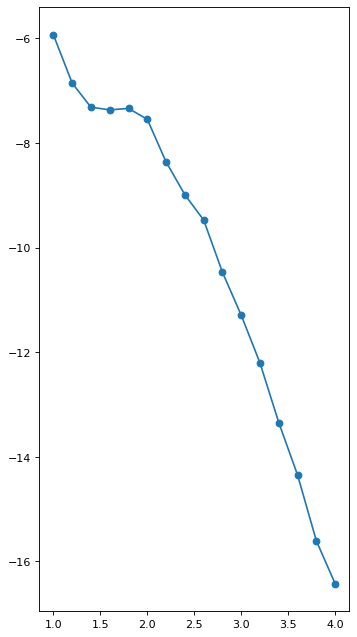

In [25]:
plot_lambda(lambda_YY)

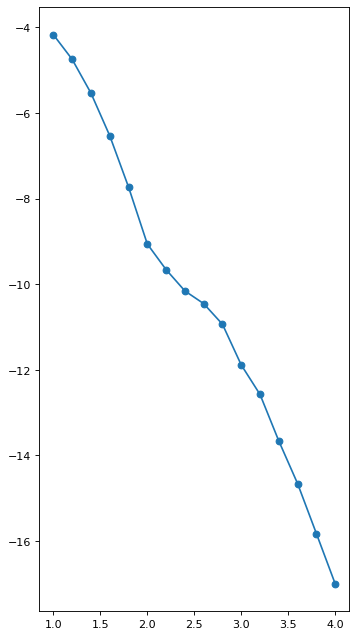

In [26]:
plot_lambda(lambda_YZ)